In [1]:
import time
import numpy as np
import cv2
from numpy import int16, uint8, log2
import pydvs.generate_spikes as gs

%matplotlib inline

# defines

In [2]:

# -------------------------------------------------------------------- #
# grab / rescale frame                                                 #

def grab_first(dev, res):
  _, raw = dev.read()
  height, width, _ = raw.shape
  new_height = res
  new_width = int( float(new_height*width)/float(height) )
  col_from = (new_width - res)//2
  col_to   = col_from + res
  img = cv2.resize(cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY).astype(int16),
               (new_width, new_height))[:, col_from:col_to]

  return img, new_width, new_height, col_from, col_to

def grab_frame(dev, width, height, col_from, col_to):
  _, raw = dev.read()
  img = cv2.resize(cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY).astype(int16),
               (width, height))[:, col_from:col_to]

  return img

In [3]:
#----------------------------------------------------------------------#
#mode 16 32 64 128
#0 up polar 1 down 2 merge pollar

video_dev_id = 0
mode = "128"
cam_res = int(mode)
width = cam_res # square output
height = cam_res
shape = (height, width)
#cam_res = 256 # <- can be done, but spynnaker doesn't suppor such resolution

data_shift = uint8( log2(cam_res) )
up_down_shift = uint8(2*data_shift)
data_mask = uint8(cam_res - 1)

polarity = 2

history_weight = 1.0#1.0
threshold = 12 # ~ 0.05*255
max_threshold = 180 # 12*15 ~ 0.7*255

scale_width = 0
scale_height = 0
col_from = 0
col_to = 0

curr     = np.zeros(shape,     dtype=int16) 
ref      = 128*np.ones(shape,  dtype=int16) 
spikes   = np.zeros(shape,     dtype=int16) 
diff     = np.zeros(shape,     dtype=int16) 
abs_diff = np.zeros(shape,     dtype=int16) 

# just to see things in a window
spk_img  = np.zeros((height, width, 3), uint8)

num_bits = 6   # how many bits are used to represent exceeded thresholds
num_active_bits = 2 # how many of bits are active
log2_table = gs.generate_log2_table(num_active_bits, num_bits)[num_active_bits - 1]
spike_lists = None
pos_spks = None
neg_spks = None
max_diff = 0


In [7]:







# -------------------------------------------------------------------- #
# inhibition related                                                   #

inh_width = 2
is_inh_on = True
inh_coords = gs.generate_inh_coords(width, height, inh_width)


# -------------------------------------------------------------------- #
# camera/frequency related                                             #

video_dev = cv2.VideoCapture(video_dev_id) # webcam
#video_dev = cv2.VideoCapture('/path/to/video/file') # webcam

print(video_dev.isOpened())

#ps3 eyetoy can do 125fps
try:
  video_dev.set(cv2.CAP_PROP_FPS, 125)
except:
  pass
  
fps = video_dev.get(cv2.CAP_PROP_FPS)
if fps == 0.0:
  fps = 125.0
max_time_ms = int(1000./float(fps))



True


In [13]:

#---------------------- main loop -------------------------------------#
LOOP_START =True
if video_dev.isOpened()==False:
    print("error in camera")
    LOOP_START = False
    

WINDOW_NAME = 'spikes'
cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
cv2.startWindowThread()

is_first_pass = True
start_time = time.time()
end_time = 0
frame_count = 0

pTime =0
curr[:], scale_width, scale_height, col_from, col_to = grab_first(video_dev, cam_res)
while(LOOP_START):
  # get an image from video source
  curr[:] = grab_frame(video_dev, scale_width,  scale_height, col_from, col_to)
  
  # do the difference
  diff[:], abs_diff[:], spikes[:] = gs.thresholded_difference(curr, ref, threshold)
  
  # inhibition ( optional ) 
  if is_inh_on:
    spikes[:] = gs.local_inhibition(spikes, abs_diff, inh_coords, 
                                 width, height, inh_width)
  
  # update the reference
  ref[:] = gs.update_reference_time_binary_thresh(abs_diff, spikes, ref,
                                               threshold, max_time_ms,
                                               num_active_bits,
                                               history_weight,
                                               log2_table)
  
  # convert into a set of packages to send out
  neg_spks, pos_spks, max_diff = gs.split_spikes(spikes, abs_diff, polarity)
  
  # this takes too long, could be parallelized at expense of memory
  spike_lists = gs.make_spike_lists_time_bin_thr(pos_spks, neg_spks,
                                              max_diff,
                                              up_down_shift, data_shift, data_mask,
                                              max_time_ms,
                                              threshold, 
                                              max_threshold,
                                              num_bits,
                                              log2_table)
  
  spk_img[:] = gs.render_frame(spikes, curr, cam_res, cam_res, polarity)

  #cTime = time.time()
  #fps = 1 / (cTime - pTime)
  #pTime = cTime
    
  #show
  fm=np.copy(spikes.astype(uint8))
  cv2.imshow (WINDOW_NAME, spk_img.astype(uint8)) 
  cv2.putText(fm,f'FPS: {int(fps)}',(0,0),cv2.FONT_HERSHEY_PLAIN,3,(8,255,8),3)

  #---------------------------------------------------
  rows,cols = np.where(spikes==-1)
  imges=np.zeros([width,height,1],np.uint8)
  imges[rows,cols]=255

  kernel = np.ones((3,3),np.uint8)
  #opening = cv2.morphologyEx(fm, cv2.MORPH_OPEN, kernel)
  closing = cv2.morphologyEx(imges, cv2.MORPH_CLOSE, kernel)
  dilation = cv2.dilate(closing,kernel,iterations = 3)
  opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)

  img=opening

  cv2.imshow ("spikes1", img) 

  # Take only region of logo from logo image.
  img2_fg = cv2.bitwise_and(spk_img,spk_img,mask = img) 
  cv2.imshow('output',img2_fg)
  #contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  #cv2.drawContours(img,contours,-1,(255,255,255),3)  
  #cv2.imshow('output',img)

  ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  #img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  imges11=np.zeros([width,height,3],np.uint8)
  cv2.drawContours(imges11,contours,-1,(255,0,255),3)
  cv2.imshow('output1',imges11)

  try: hierarchy = hierarchy[0]
  except: hierarchy = []

  min_x, min_y = width, height
  max_x = max_y = 0

  # computes the bounding box for the contour, and draws it on the frame,
  for contour, hier in zip(contours, hierarchy):
      (x,y,w,h) = cv2.boundingRect(contour)
      min_x, max_x = min(x, min_x), max(x+w, max_x)
      min_y, max_y = min(y, min_y), max(y+h, max_y)
      if w > 10 and h > 10  and w<150 and h<150:
          cv2.rectangle(imges11, (x,y), (x+w,y+h), (255, 0, 0), 2)

  if max_x - min_x > 10 and max_y - min_y > 10 and max_y - min_y < 150 and max_x - min_x<150:
      cv2.rectangle(imges11, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
  cv2.imshow('output2',imges11)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  
  end_time = time.time()
  
  if end_time - start_time >= 1.0:
    print("%d frames per second"%(frame_count))
    frame_count = 0
    start_time = time.time()
  else:
    frame_count += 1

cv2.destroyAllWindows()

error in camera


AttributeError: 'NoneType' object has no attribute 'shape'

In [8]:
def Base_work(curr,spikes):
    # get an image from video source
  curr[:] = grab_frame(video_dev, scale_width,  scale_height, col_from, col_to)
  curr = cv2.medianBlur(curr,5)
  
  # do the difference
  diff[:], abs_diff[:], spikes[:] = gs.thresholded_difference(curr, ref, threshold)
  
  # inhibition ( optional ) 
  if is_inh_on:
    spikes[:] = gs.local_inhibition(spikes, abs_diff, inh_coords, 
                                 width, height, inh_width)
  
  # update the reference
  ref[:] = gs.update_reference_time_binary_thresh(abs_diff, spikes, ref,
                                               threshold, max_time_ms,
                                               num_active_bits,
                                               history_weight,
                                               log2_table)
  
  # convert into a set of packages to send out
  neg_spks, pos_spks, max_diff = gs.split_spikes(spikes, abs_diff, polarity)
  
  # this takes too long, could be parallelized at expense of memory
  spike_lists = gs.make_spike_lists_time_bin_thr(pos_spks, neg_spks,
                                              max_diff,
                                              up_down_shift, data_shift, data_mask,
                                              max_time_ms,
                                              threshold, 
                                              max_threshold,
                                              num_bits,
                                              log2_table)
  
  spk_img[:] = gs.render_frame(spikes, curr, cam_res, cam_res, polarity)

  #show
  fm=np.copy(spikes.astype(uint8))
  cv2.imshow (WINDOW_NAME, spk_img.astype(uint8)) 
  cv2.putText(fm,f'FPS: {int(fps)}',(0,0),cv2.FONT_HERSHEY_PLAIN,3,(8,255,8),3)

In [9]:
def get_white_frame(spikes):
  rows,cols = np.where(spikes==-1)
  imgesR=np.zeros([width,height,1],np.uint8)
  imgesR[rows,cols]=255
  rows,cols = np.where(spikes==1)
  imgesG=np.zeros([width,height,1],np.uint8)
  imgesG[rows,cols]=255
  rows,cols = np.where(spikes!=0)
  imges=np.zeros([width,height,1],np.uint8)
  imges[rows,cols]=255
  return imgesR,imgesG,imges

In [61]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [83]:
def singlefilter(img,step,windowsize,tresh):
    img2= img
    for (x, y, window) in sliding_window(img2, stepSize=step, windowSize=windowsize):
        if(np.count_nonzero(window))>=tresh:
            pass
        else :
            img2[x,y]=0
    return img2

In [147]:
def base_filter(imgesR,imgesG,imges):
  kernel = np.ones((2,1),np.uint8)
  kernel2 = np.ones((2,2),np.uint8)
  kernel3 = np.ones((2,2),np.uint8)
  kernelp = np.ones((1,2),np.uint8)
  
  #opening = cv2.morphologyEx(fm, cv2.MORPH_OPEN, kernel)
  #closing = cv2.morphologyEx(imges, cv2.MORPH_CLOSE, kernel)
  #dilation = cv2.dilate(closing,kernel,iterations = 3)
  #opening = cv2.morphologyEx(dilation, cv2.MORPH_OPEN, kernel)



  #dilationR = cv2.dilate(imgesR,kernel,iterations = 2)
  #dilationG = cv2.dilate(imgesG,kernel,iterations = 2)
  #img=cv2.erode(dilationR,kernel,iterations = 4)
  rimg = imgesR
  #rimg = cv2.morphologyEx(imgesR,cv2.MORPH_CLOSE,kernel,iterations = 1)
  #rimg = cv2.erode(imgesR,kernel3,iterations = 5)
  #rimg = singlefilter(rimg,1,(3,3),2)
  rimgNOT = cv2.bitwise_not(rimg)  # could just use 255-img

  kernel1 = np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]], np.uint8)
  kernel2 = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]], np.uint8)

  kernel1 = np.zeros((3,3),np.uint8)
  kernel1[1,1] = 1
  kernel2 = np.ones((3,3),np.uint8)
  kernel2[1,1]=0

  hitormiss1 = cv2.morphologyEx(rimg, cv2.MORPH_ERODE, kernel1)
  hitormiss2 = cv2.morphologyEx(rimgNOT, cv2.MORPH_ERODE, kernel2)
  hitormiss = cv2.bitwise_and(hitormiss1, hitormiss2)

  hitormiss_comp = cv2.bitwise_not(hitormiss)  # could just use 255-img
  del_isolated = cv2.bitwise_and(rimg, rimg, mask=hitormiss_comp)

  rimg= del_isolated

  ret,thresh = cv2.threshold(rimg,127,255,cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  #img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  imges11=np.zeros([width,height,3],np.uint8)
  cv2.drawContours(imges11,contours,-1,(255,0,255),3)
  cv2.imshow('output1',imges11)

  try: hierarchy = hierarchy[0]
  except: hierarchy = []

  min_x, min_y = width, height
  max_x = max_y = 0

  # computes the bounding box for the contour, and draws it on the frame,
  for contour, hier in zip(contours, hierarchy):
      (x,y,w,h) = cv2.boundingRect(contour)
      min_x, max_x = min(x, min_x), max(x+w, max_x)
      min_y, max_y = min(y, min_y), max(y+h, max_y)
      if w > 10 and h > 10  and w<150 and h<150:
          cv2.rectangle(imges11, (x,y), (x+w,y+h), (255, 0, 0), 2)

  if max_x - min_x > 10 and max_y - min_y > 10 and max_y - min_y < 150 and max_x - min_x<150:
      cv2.rectangle(imges11, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
  cv2.imshow('output2',imges11)







  

  
  
  #for noise reduction
  #img = cv2.medianBlur(imgesR,2)
  openingG = cv2.morphologyEx(imgesG,cv2.MORPH_CLOSE,kernel3, iterations = 1)
  openingR = cv2.morphologyEx(imgesR,cv2.MORPH_OPEN,kernel, iterations = 1)
  opening = cv2.morphologyEx(imges,cv2.MORPH_OPEN,kernel2, iterations = 1 )

  #openingG = cv2.dilate(openingG,kernel2,iterations=1)
  #---------------------------------
  # Finding sure foreground area
  #openingG = cv2.distanceTransform(openingG,cv2.DIST_L2,5)
  #ret, openingG = cv2.threshold(openingG,0.6*openingG.max(),255,0)

  #openingG = cv2.morphologyEx(openingG, cv2.MORPH_CLOSE, kernel2)

  #openingG = cv2.dilate(openingG,kernel3,iterations=5)

  #sure_bg = cv2.dilate(opening,kernel,iterations=3)
  #sure_bg = cv2.dilate(opening,kernel,iterations=3)


  cv2.imshow ("RAW NOISE", imgesR) 
  #cv2.imshow ("morphologyG", openingG)
  #cv2.imshow ("morphology", opening)
  openingR = rimg

  cv2.imshow ("test R", rimg)

  imgG = openingG
  imgR = openingR
  img  = opening
  #cv2.imshow ("morphologyG", dilationG) 
  return img,imgG,imgR

In [149]:
#---------------------- main loop -------------------------------------#
LOOP_START =True
if video_dev.isOpened()==False:
    print("error in camera")
    LOOP_START = False
    

WINDOW_NAME = 'spikes'
cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
cv2.startWindowThread()

is_first_pass = True
start_time = time.time()
end_time = 0
frame_count = 0

pTime =0
curr[:], scale_width, scale_height, col_from, col_to = grab_first(video_dev, cam_res)
while(LOOP_START):
  #get spikes and prepare them  
  Base_work(curr,spikes)
  
  #get spike on white frame
  imgesR,imgesG,imges = get_white_frame(spikes)

  #---------------------------------------------------
  #first filter
  img,imgG,imgR = base_filter(imgesR,imgesG,imges)

  ret,thresh = cv2.threshold(imgR,127,255,cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  #img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  imges11=np.zeros([128,128,3],np.uint8)
  cv2.drawContours(imges11,contours,-1,(255,0,255),3)
  cv2.imshow('output1',imges11)
  

  
  '''
  # Take only region of logo from logo image.
  img2_fg = cv2.bitwise_and(spk_img,spk_img,mask = img) 
  cv2.imshow('output',img2_fg)
  #contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  #cv2.drawContours(img,contours,-1,(255,255,255),3)  
  #cv2.imshow('output',img)

  ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  #img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
  imges11=np.zeros([128,128,3],np.uint8)
  cv2.drawContours(imges11,contours,-1,(255,0,255),3)
  cv2.imshow('output1',imges11)

  try: hierarchy = hierarchy[0]
  except: hierarchy = []

  min_x, min_y = width, height
  max_x = max_y = 0

  # computes the bounding box for the contour, and draws it on the frame,
  for contour, hier in zip(contours, hierarchy):
      (x,y,w,h) = cv2.boundingRect(contour)
      min_x, max_x = min(x, min_x), max(x+w, max_x)
      min_y, max_y = min(y, min_y), max(y+h, max_y)
      if w > 10 and h > 10  and w<150 and h<150:
          cv2.rectangle(imges11, (x,y), (x+w,y+h), (255, 0, 0), 2)

  if max_x - min_x > 10 and max_y - min_y > 10 and max_y - min_y < 150 and max_x - min_x<150:
      cv2.rectangle(imges11, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
  cv2.imshow('output2',imges11)

  '''
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  
  end_time = time.time()
  
  if end_time - start_time >= 1.0:
    print("%d frames per second"%(frame_count))
    frame_count = 0
    start_time = time.time()
  else:
    frame_count += 1

cv2.destroyAllWindows()

27 frames per second
28 frames per second
28 frames per second
29 frames per second
28 frames per second
29 frames per second
28 frames per second
29 frames per second
29 frames per second
29 frames per second
28 frames per second
28 frames per second
28 frames per second
28 frames per second
29 frames per second
29 frames per second
28 frames per second
29 frames per second
28 frames per second
25 frames per second
27 frames per second
29 frames per second
28 frames per second
28 frames per second
28 frames per second
29 frames per second
28 frames per second
28 frames per second
28 frames per second
28 frames per second
25 frames per second
29 frames per second
28 frames per second
28 frames per second
18 frames per second
13 frames per second
27 frames per second
28 frames per second
29 frames per second
28 frames per second
29 frames per second
28 frames per second
28 frames per second
28 frames per second
29 frames per second
28 frames per second
29 frames per second
28 frames per

In [ ]:
cv2.namedWindow("spikes2", cv2.WINDOW_AUTOSIZE)
cv2.startWindowThread()
cv2.imshow ("spikes2", spikes.astype(uint8)) 
while True:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()



In [17]:
cv2.destroyAllWindows()

In [19]:
np.where(spikes == -1)

(array([ 42,  53,  81,  81,  82,  83,  83,  84,  84,  89,  90,  91,  91,
         91,  92,  92,  92,  93,  93,  93,  93,  93,  93,  94,  94,  94,
         94,  95,  95,  95,  95,  95,  95,  96,  96,  97,  97,  97,  97,
         97,  97,  98,  98,  98,  98,  98,  98,  99,  99,  99,  99,  99,
        100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101,
        102, 102, 102, 102, 103, 103, 103, 103, 104, 104, 104, 105, 105,
        106, 108, 108, 110, 110, 110, 110, 111, 111, 111, 111, 112, 112,
        112, 113, 113, 114, 114, 114, 115, 115, 115, 115, 116, 117, 117,
        117, 117, 118, 118, 118, 118, 120, 120, 121, 122, 122, 123, 123,
        123, 124, 124, 124, 125, 126, 127, 127]),
 array([116, 118,  85,  86,  96,  98, 100,  74, 100,  83, 105,  77,  96,
        106,  77,  81, 105,  64,  74,  97,  98, 101, 102,  96,  98, 101,
        105,  65,  73,  74,  92,  95, 102,  73,  90,  89,  93,  94,  97,
         99, 101,  73,  87,  90,  95,  97,  98,  65,  83,  85,  88,  92,
 

In [21]:
spikes[42][116]

-1

In [28]:
rows, cols = np.where(spikes != 0)

In [29]:
print(rows.shape)
print(cols.shape)

(357,)
(357,)


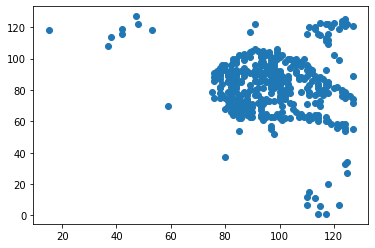

In [42]:
plt.scatter(rows, cols)

In [38]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

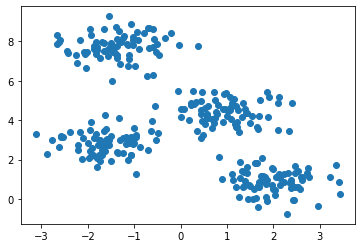

In [41]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

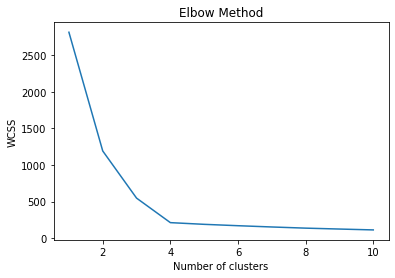

In [44]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

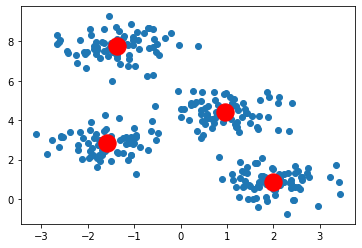

In [45]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

(357, 2)


In [57]:
Y=np.zeros([rows.size,2])
Y[:,0]=rows
Y[:,1]=cols

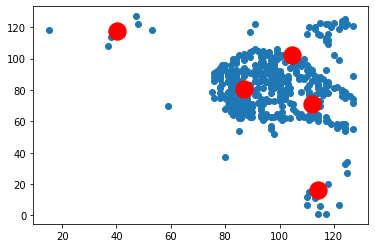

In [62]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(Y)
plt.scatter(Y[:,0], Y[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

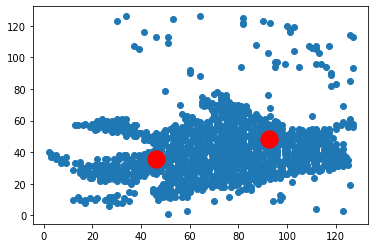

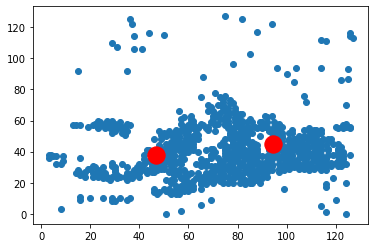

1 frames per second


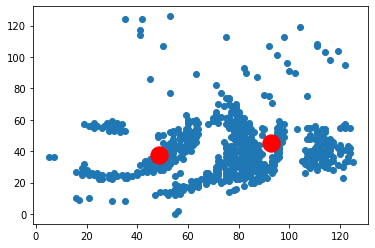

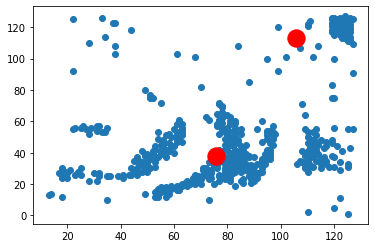

1 frames per second


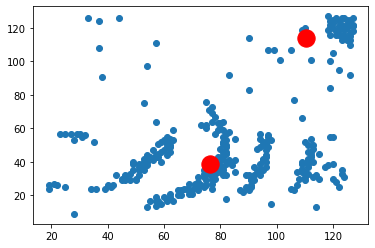

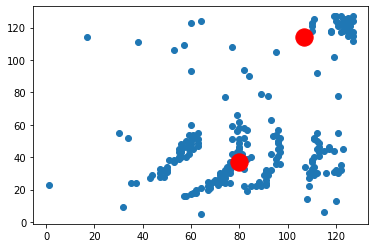

1 frames per second


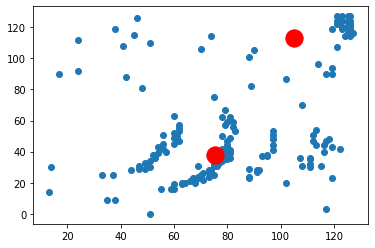

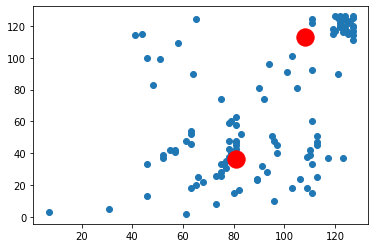

1 frames per second


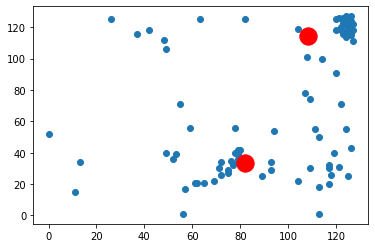

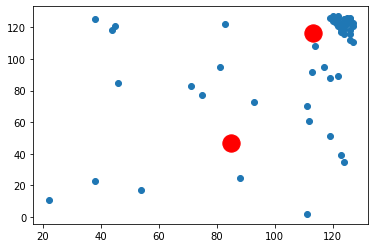

1 frames per second


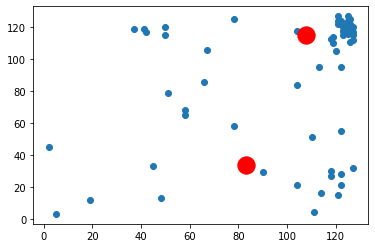

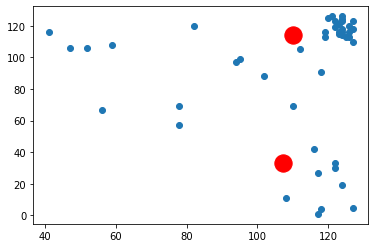

1 frames per second


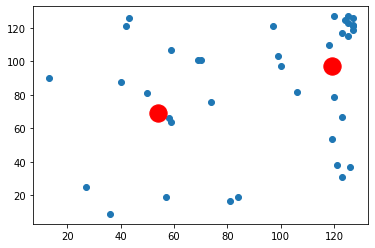

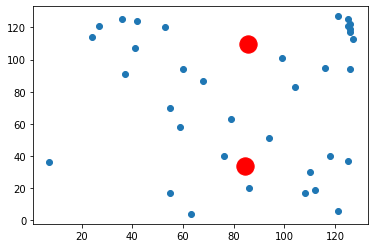

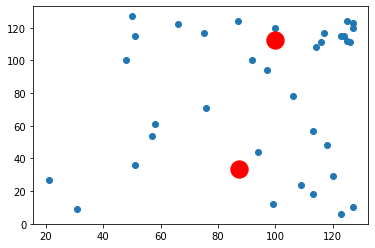

2 frames per second


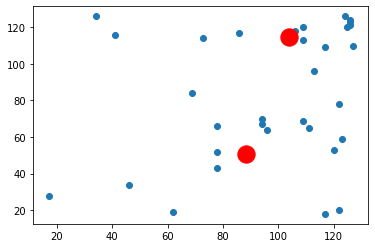

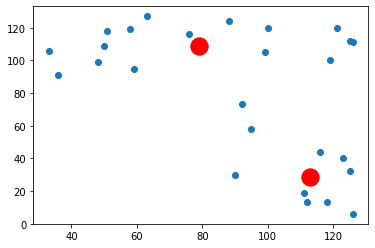

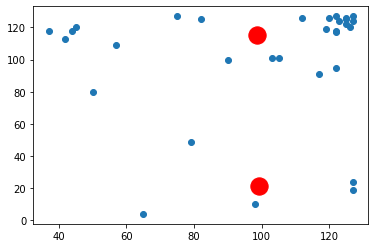

2 frames per second


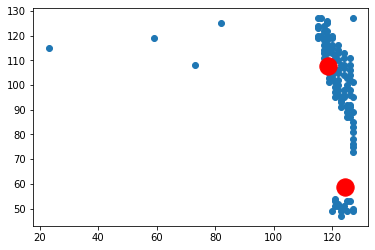

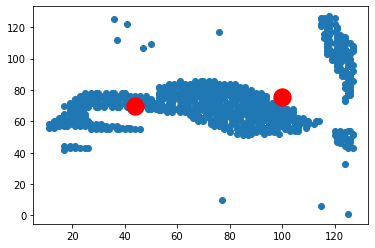

1 frames per second


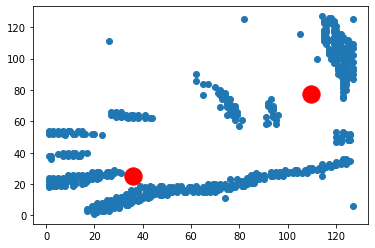

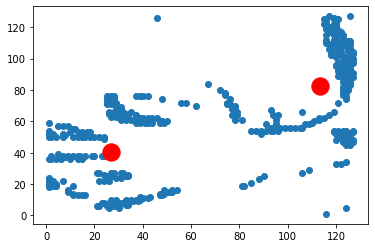

1 frames per second


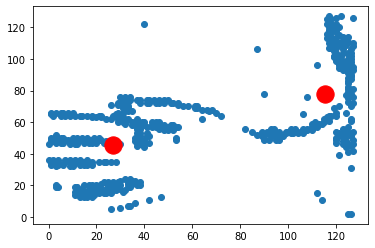

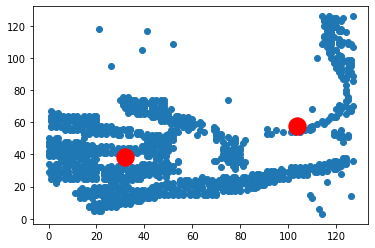

1 frames per second


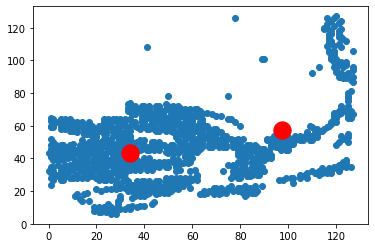

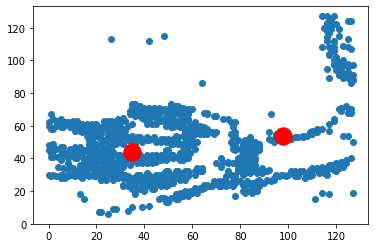

1 frames per second


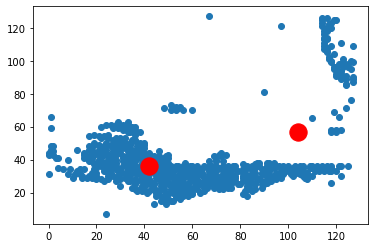

0 frames per second


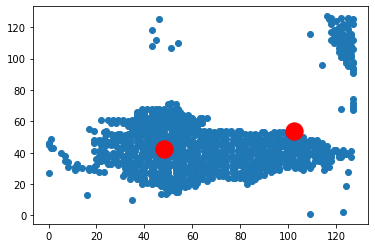

0 frames per second


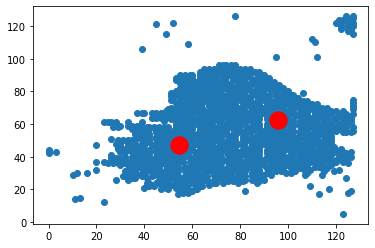

0 frames per second


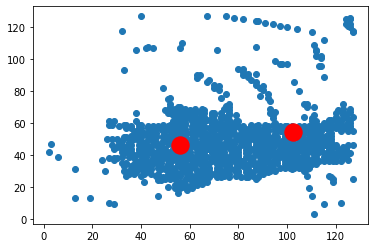

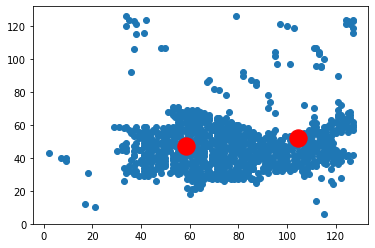

1 frames per second


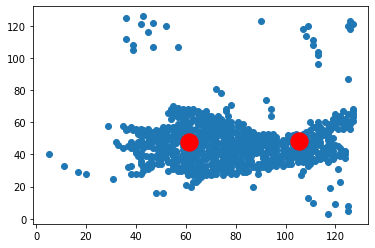

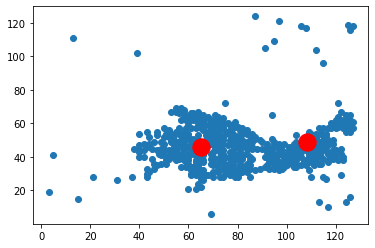

1 frames per second


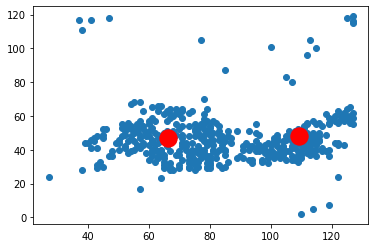

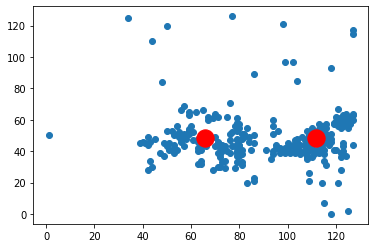

1 frames per second


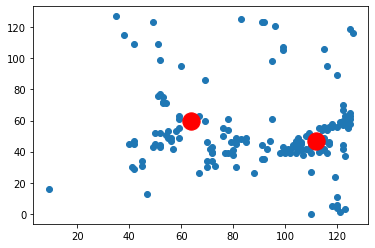

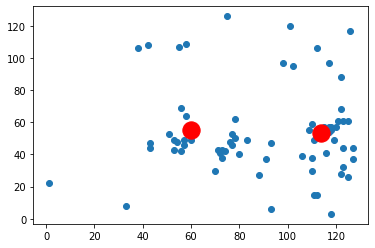

1 frames per second


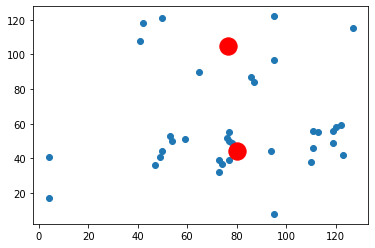

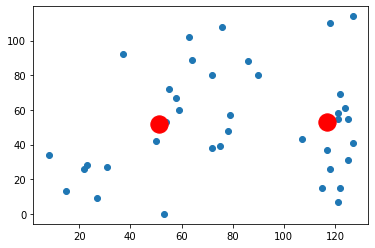

1 frames per second


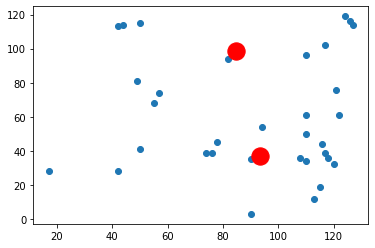

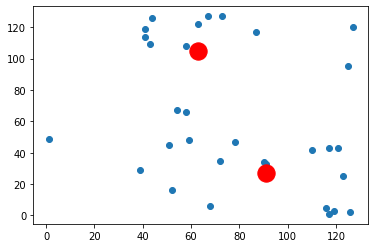

1 frames per second


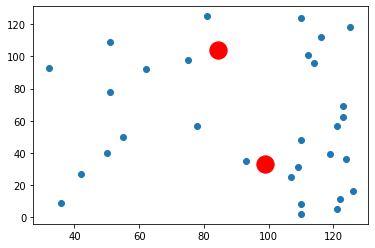

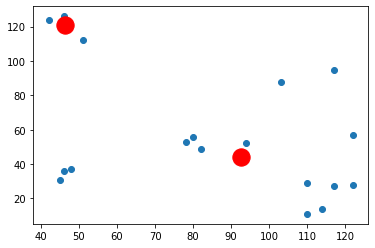

1 frames per second


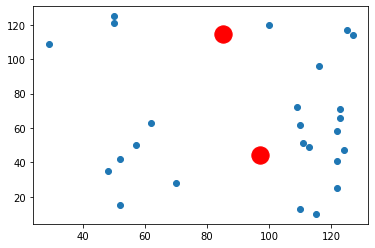

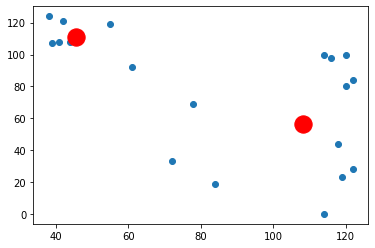

1 frames per second


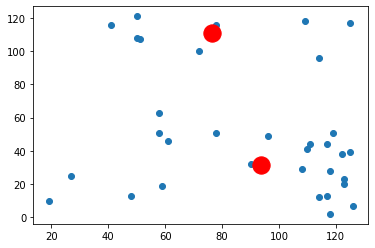

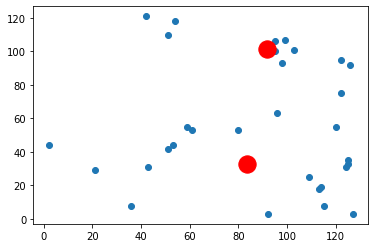

1 frames per second


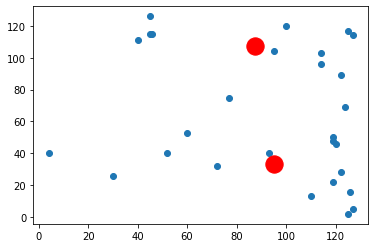

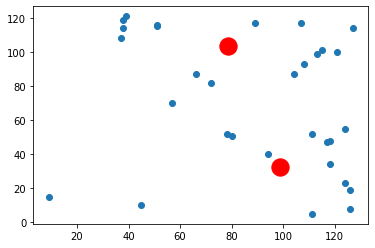

1 frames per second


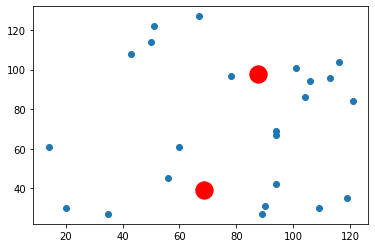

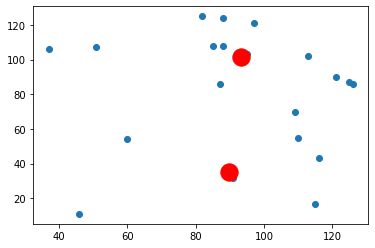

1 frames per second


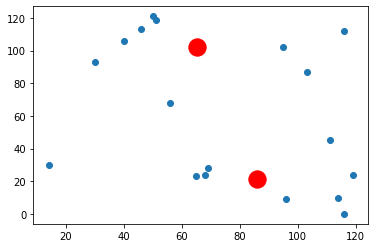

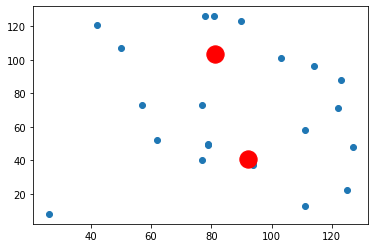

1 frames per second


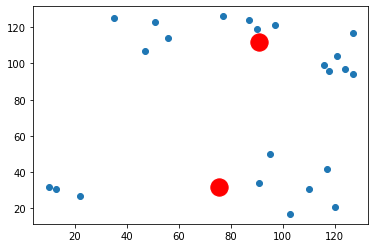

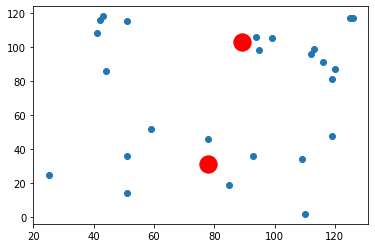

1 frames per second


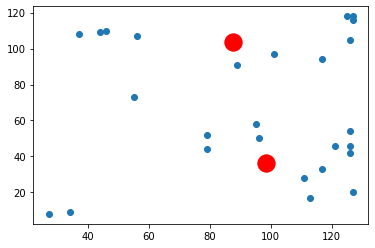

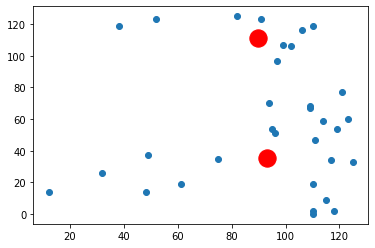

1 frames per second


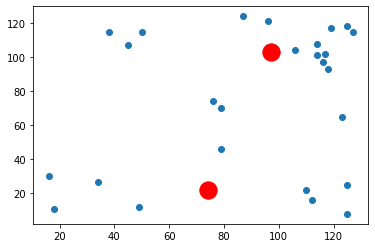

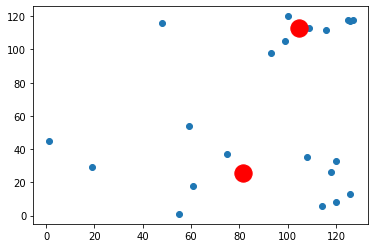

In [66]:

#---------------------- main loop -------------------------------------#
LOOP_START =True
if video_dev.isOpened()==False:
    print("error in camera")
    LOOP_START = False
    

WINDOW_NAME = 'spikes'
cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_AUTOSIZE)
cv2.startWindowThread()

is_first_pass = True
start_time = time.time()
end_time = 0
frame_count = 0

pTime =0
curr[:], scale_width, scale_height, col_from, col_to = grab_first(video_dev, cam_res)
while(LOOP_START):
  # get an image from video source
  curr[:] = grab_frame(video_dev, scale_width,  scale_height, col_from, col_to)
  
  # do the difference
  diff[:], abs_diff[:], spikes[:] = gs.thresholded_difference(curr, ref, threshold)
  
  # inhibition ( optional ) 
  if is_inh_on:
    spikes[:] = gs.local_inhibition(spikes, abs_diff, inh_coords, 
                                 width, height, inh_width)
  
  # update the reference
  ref[:] = gs.update_reference_time_binary_thresh(abs_diff, spikes, ref,
                                               threshold, max_time_ms,
                                               num_active_bits,
                                               history_weight,
                                               log2_table)
  
  # convert into a set of packages to send out
  neg_spks, pos_spks, max_diff = gs.split_spikes(spikes, abs_diff, polarity)
  
  # this takes too long, could be parallelized at expense of memory
  spike_lists = gs.make_spike_lists_time_bin_thr(pos_spks, neg_spks,
                                              max_diff,
                                              up_down_shift, data_shift, data_mask,
                                              max_time_ms,
                                              threshold, 
                                              max_threshold,
                                              num_bits,
                                              log2_table)
  
  spk_img[:] = gs.render_frame(spikes, curr, cam_res, cam_res, polarity)

  #cTime = time.time()
  #fps = 1 / (cTime - pTime)
  #pTime = cTime
    
  #show
  fm=np.copy(spikes.astype(uint8))
  cv2.imshow (WINDOW_NAME, spk_img.astype(uint8)) 
  cv2.putText(fm,f'FPS: {int(fps)}',(0,0),cv2.FONT_HERSHEY_PLAIN,3,(8,255,8),3)
  cv2.imshow ("spikes1", fm) 

  rows, cols = np.where(spikes == 1)

  Y=np.zeros([rows.size,2])
  Y[:,0]=rows
  Y[:,1]=cols

  kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=50, n_init=10, random_state=0)
  pred_y = kmeans.fit_predict(Y)
  plt.scatter(Y[:,0], Y[:,1])
  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
  plt.show()


  
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  
  end_time = time.time()
  
  if end_time - start_time >= 1.0:
    print("%d frames per second"%(frame_count))
    frame_count = 0
    start_time = time.time()
  else:
    frame_count += 1

cv2.destroyAllWindows()

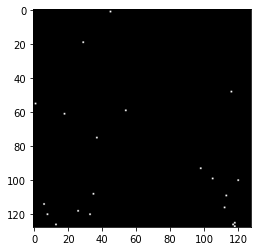

21

In [9]:
import cv2
import numpy as np

img=np.zeros([width,height,1],np.uint8)
img[rows,cols]=255


kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)

plt.imshow(erosion,'gray')



NameError: name 'rows' is not defined

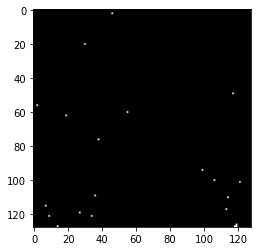

In [97]:

img=np.zeros([width,height,1],np.uint8)
img[rows,cols]=255


kernel = np.ones((2,2),np.uint8)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.imshow(closing,'gray')



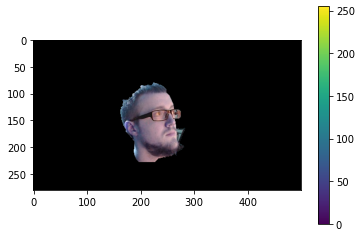

In [128]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('opencv-python-foreground-extraction-tutorial.jpg')
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (161,79,150,150)

cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.colorbar()
plt.show()



In [52]:
test = np.zeros((16,16))


In [55]:
test

array([[  0., 255.,   0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 255.,   0., 255.,   0., 255.,   0.,   0.,   0.,
          0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,
          0., 255.,   0.,   0.,   0.],
       [255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.,
          0., 255.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255., 255.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   

In [54]:
test[np.random.choice(16, 20),np.random.choice(16, 20)]=255

In [48]:
rowsTest,colsTest = np.where(test==255)
imges=np.zeros([width,height,1],np.uint8)
imges[rows,cols]=255

array([ 56,  51, 115,  21,  88,  32,  24,  17,  12,  19,  10, 123,  48,
        47, 105,  92, 118,  86,  65,   8])

In [56]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [59]:
for (x, y, window) in sliding_window(test, stepSize=1, windowSize=(3, 3)):
     if(np.count_nonzero(window))>=2:
         pass
     else :
         test[x,y]=0

In [60]:
test

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 255.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   